# Exercise 3: Convolutional Neural Networks

Gruppo Stocafisici: Edoardo Antonaci, Angelica Foroni, Francesco Mazza, Leonardo Salicari.

1. Experiment with different architectures (which was left as an open point when “NCONV”
variable was introduced), in particular try at least another version where only one
convolutional layer is introduced instead of two, and where any number of dense layers may
be used, with the global constraint of using a network with at most 600 trainable parameters.
The filter length in the second convolutional layer may be shorter.
Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?
Check which configuration works better by comparing the performances quantitatively.
2. Visualize the “confusion matrix” (look for similar examples in the material available or by
googling)
3. With two convolutional layers, plot also the weights of the second layer and try to see if
regularization may improve the performances by varying the parameter lambda of the L1 or
of the L2 regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed
version (l1_l2?) that can be tried. Is any value of lambda good? Is there any intermediate
value where the performances of the network are better? Is there any improvement in the
visualization and understanding of the weights in the filters? Note that the regularization we
introduced acts on the w’s, not on the biases. One can also try the equivalent procedure for
biases or for the output of the relu units (see Keras doc.), if there is any reason for
suspecting that it may help. In our case, the logic was to let the weights of the filters go to
zero if not needed, hence that kind of regularization was selected.
4. By reducing the signal-to-noise ratio, namely the amplitude of the external signal in the data
(A) with respect to the step typical size of the jump process, check where the network starts
to fail discriminating the categories.

### Loading dataset
We are going to use the dataset generated during the lecture

In [14]:
import subprocess,csv
import random
import math
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
xname = 'DATA/x' + name
yname = 'DATA/y' + name

# Dataset
x = np.loadtxt(xname, delimiter=',', dtype=float)
N = x.shape[0]
L = x.shape[1]

# Labels
categ = np.loadtxt(yname, delimiter=',', dtype=int)
n_class = 3
y = np.zeros((N, n_class ))
for i in range(N):
    y[i][categ[i]] = 1.

# Removing avg and scaling data
x_avg = np.mean(x, axis=1).reshape(N,1) # average over sample (i.e. over rows)
x = (x - x_avg)/100 # one line to remove avg and scale; faster than a for loop
    
# Training and Validation
# Note, these are view, not copies
train_frac = .8
N_train = int(N*train_frac)
x_train = x[0:N_train,:]
y_train = y[0:N_train,:]
x_val = x[N_train:,:]
y_val = y[N_train:,:]

# Plotting some data
for k in range(3):
    plt.plot(x_train[k])
    
# Reshape for Keras
# Hence adding an extra dim wich correspond to the depth 
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)

input_size = (L,1)

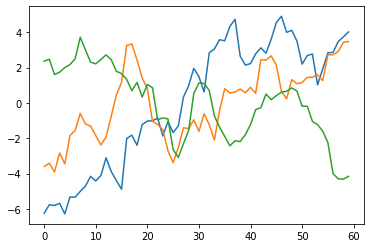

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
xname = fname
yname = 'y' + name

# Dataset
x = np.loadtxt(xname, delimiter=',', dtype=float)
N = x.shape[0]
L = x.shape[1]

# Labels
categ = np.loadtxt(yname, delimiter=',', dtype=int)
n_class = 3
y = np.zeros((N, n_class ))
for i in range(N):
    y[i][categ[i]] = 1.

# Removing avg and scaling data
x_avg = np.mean(x, axis=1).reshape(N,1) # average over sample (i.e. over rows)
x = (x - x_avg)/100 # one line to remove avg and scale; faster than a for loop
    
# Training and Validation
# Note, these are view, not copies
train_frac = .8
N_train = int(N*train_frac)
x_train = x[0:N_train,:]
y_train = y[0:N_train,:]
x_val = x[N_train:,:]
y_val = y[N_train:,:]

# Plotting some data
for k in range(3):
    plt.plot(x_train[k])
    
# Reshape for Keras
# Hence adding an extra dim wich correspond to the depth 
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)

input_size = (L,1)

## 1: CNN with different topologies

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils.layer_utils import count_params # for count number of parameters
from keras.losses import categorical_crossentropy
from keras import initializers, regularizers
from keras import optimizers

def create_model(NCONV=1, n_dense_layers=1, kernel_size_diff=1, summary=False):
    ''' 
    Creates a CNN with different topologies by changing NCONV 
    Returns the model and the number of trainable parameters
    
    n_dense_layers = number of dense layers in the CNN
    kernel_size_diff = (kernel_size first Conv layer) - (kernel_size second Conv layer)
    summary = print model.summary()
    
    NCONV == 1:
        From baiesi lecture
        Conv -> AvgPadding -> Conv -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
    NCONV == 2: 
        Only one Conv layer
        Conv -> AvgPadding -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
        
    '''
    if n_dense_layers < 1:
        raise('n_dense_layer must be int and >= 1')
        
    # Defining regulirizer
    reg = regularizers.l1(0.1)
    # Used to initialize kernel 
    init = initializers.RandomNormal(mean = 0,
                                   stddev = .05)
    model = Sequential()

    if NCONV == 1:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Conv1D(filters=5, 
                          kernel_size = 11 - kernel_size_diff, 
                          activation = 'relu',) )
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
        
    elif NCONV == 2:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
    else:
        raise('NCONV must be an int: 1 or 2')
        
    # Output layer
    model.add(Dense(n_class, activation='softmax')) 
    
    # print model's details
    if summary: print(model.summary())
    # Number of trainable parameters
    trainable_count = count_params(model.trainable_weights)
    
    # Compiling model
    opt = optimizers.Nadam()
    model.compile( loss = categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])
    
    return (model, trainable_count)

### Training and test performance

 Is the number of parameters scaling more quickly by adding Dense layers or Conv1D layers?

Text(0, 0.5, '# of trainable parameters')

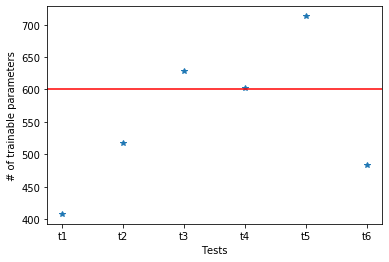

In [21]:
# Define dicts to test different topologies
# t1 == test 1
t1 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 1)
t2 = dict(NCONV = 1, n_dense_layers = 2, kernel_size_diff = 1)
t3 = dict(NCONV = 1, n_dense_layers = 3, kernel_size_diff = 1)
t4 = dict(NCONV = 2, n_dense_layers = 1, kernel_size_diff = 1)
t5 = dict(NCONV = 2, n_dense_layers = 2, kernel_size_diff = 1)
t6 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 4)

# Array with tests
tests = [t1,t2,t3,t4,t5,t6]
# Array with names for plotting porpuses
tests_plot = ['t1','t2','t3','t4','t5','t6']
# Array to save # of parameters
params = [0] * len(tests)

for idx,t in enumerate(tests):
    _, params[idx] = create_model(**t, summary=False) # **t is the syntax to 'unpack' values from dict
    
# Visualising number of parameters
plt.close()
plt.plot(tests_plot, params, '*')
plt.axhline(y=600, color='red') # line of 600 parameters
plt.xlabel('Tests')
plt.ylabel('# of trainable parameters')

#### Comment
It's seems like that removing a `Conv1D` layer the number of trainable parameters grows. Looking at the summary of the models, this apparent contradiction seems to be solve by the fact that in the case of 2 convolutional layers the `output size` of the layer's output is smaller compared to the model with only one convolutional layer.

Than, the fully connected layers (the `Dense` one) han a number of trainable parameters related to the number of weights and biases which grows quickly with the `output size` of the previous layer. Hence, the one-convolutional-layer model has more parameters due to its bigger output given to the fully connected layer.

For more info, use the option `summary=True` in the `create_model()` function's call.

### Performance comparison
It'll be trained models relative to configurations `t2`, `t4` and `t6`


In [22]:
model2, _ = create_model(**t2)
model4, _ = create_model(**t4)
model6, _ = create_model(**t6)

# Training
batch_size = 250
epochs = 100

fit2 = model2.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit4 = model4.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit6 = model6.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 1.2136 - accuracy: 0.3355 - val_loss: 1.1364 - val_accuracy: 0.3710
Epoch 2/100
 - 0s - loss: 1.1162 - accuracy: 0.3591 - val_loss: 1.1053 - val_accuracy: 0.3690
Epoch 3/100
 - 0s - loss: 1.1031 - accuracy: 0.3549 - val_loss: 1.1023 - val_accuracy: 0.3335
Epoch 4/100
 - 0s - loss: 1.1020 - accuracy: 0.3370 - val_loss: 1.1021 - val_accuracy: 0.3335
Epoch 5/100
 - 0s - loss: 1.1019 - accuracy: 0.3347 - val_loss: 1.1027 - val_accuracy: 0.3335
Epoch 6/100
 - 0s - loss: 1.1019 - accuracy: 0.3300 - val_loss: 1.1019 - val_accuracy: 0.3385
Epoch 7/100
 - 0s - loss: 1.1018 - accuracy: 0.3266 - val_loss: 1.1019 - val_accuracy: 0.3425
Epoch 8/100
 - 0s - loss: 1.1018 - accuracy: 0.3257 - val_loss: 1.1022 - val_accuracy: 0.3335
Epoch 9/100
 - 0s - loss: 1.1019 - accuracy: 0.3300 - val_loss: 1.1022 - val_accuracy: 0.3335
Epoch 10/100
 - 0s - loss: 1.1020 - accuracy: 0.3224 - val_loss: 1.1026 - val_accuracy: 0.3395
Epoch 11/10

Epoch 87/100
 - 0s - loss: 1.1011 - accuracy: 0.3284 - val_loss: 1.1013 - val_accuracy: 0.3335
Epoch 88/100
 - 0s - loss: 1.1011 - accuracy: 0.3274 - val_loss: 1.1013 - val_accuracy: 0.3335
Epoch 89/100
 - 0s - loss: 1.1011 - accuracy: 0.3249 - val_loss: 1.1013 - val_accuracy: 0.3335
Epoch 90/100
 - 0s - loss: 1.1010 - accuracy: 0.3216 - val_loss: 1.1013 - val_accuracy: 0.3335
Epoch 91/100
 - 0s - loss: 1.1010 - accuracy: 0.3306 - val_loss: 1.1012 - val_accuracy: 0.3335
Epoch 92/100
 - 0s - loss: 1.1010 - accuracy: 0.3273 - val_loss: 1.1012 - val_accuracy: 0.3330
Epoch 93/100
 - 0s - loss: 1.1010 - accuracy: 0.3270 - val_loss: 1.1012 - val_accuracy: 0.3330
Epoch 94/100
 - 0s - loss: 1.1010 - accuracy: 0.3298 - val_loss: 1.1013 - val_accuracy: 0.3335
Epoch 95/100
 - 0s - loss: 1.1010 - accuracy: 0.3260 - val_loss: 1.1012 - val_accuracy: 0.3335
Epoch 96/100
 - 0s - loss: 1.1010 - accuracy: 0.3259 - val_loss: 1.1012 - val_accuracy: 0.3335
Epoch 97/100
 - 0s - loss: 1.1010 - accuracy: 0.32

Epoch 73/100
 - 0s - loss: 1.0392 - accuracy: 0.4791 - val_loss: 1.0376 - val_accuracy: 0.4950
Epoch 74/100
 - 0s - loss: 1.0406 - accuracy: 0.4737 - val_loss: 1.0409 - val_accuracy: 0.4840
Epoch 75/100
 - 0s - loss: 1.0417 - accuracy: 0.4767 - val_loss: 1.0396 - val_accuracy: 0.4900
Epoch 76/100
 - 0s - loss: 1.0423 - accuracy: 0.4764 - val_loss: 1.0401 - val_accuracy: 0.4855
Epoch 77/100
 - 0s - loss: 1.0396 - accuracy: 0.4807 - val_loss: 1.0403 - val_accuracy: 0.4895
Epoch 78/100
 - 0s - loss: 1.0396 - accuracy: 0.4787 - val_loss: 1.0407 - val_accuracy: 0.4850
Epoch 79/100
 - 0s - loss: 1.0425 - accuracy: 0.4781 - val_loss: 1.0399 - val_accuracy: 0.4920
Epoch 80/100
 - 0s - loss: 1.0409 - accuracy: 0.4759 - val_loss: 1.0385 - val_accuracy: 0.4950
Epoch 81/100
 - 0s - loss: 1.0356 - accuracy: 0.4831 - val_loss: 1.0396 - val_accuracy: 0.4895
Epoch 82/100
 - 0s - loss: 1.0396 - accuracy: 0.4786 - val_loss: 1.0399 - val_accuracy: 0.4910
Epoch 83/100
 - 0s - loss: 1.0375 - accuracy: 0.48

Epoch 59/100
 - 0s - loss: 1.0998 - accuracy: 0.3530 - val_loss: 1.0998 - val_accuracy: 0.3550
Epoch 60/100
 - 0s - loss: 1.1000 - accuracy: 0.3581 - val_loss: 1.0996 - val_accuracy: 0.3485
Epoch 61/100
 - 0s - loss: 1.0993 - accuracy: 0.3640 - val_loss: 1.0971 - val_accuracy: 0.3760
Epoch 62/100
 - 0s - loss: 1.1000 - accuracy: 0.3629 - val_loss: 1.0969 - val_accuracy: 0.3755
Epoch 63/100
 - 0s - loss: 1.0990 - accuracy: 0.3641 - val_loss: 1.0960 - val_accuracy: 0.3870
Epoch 64/100
 - 0s - loss: 1.0995 - accuracy: 0.3548 - val_loss: 1.0964 - val_accuracy: 0.3780
Epoch 65/100
 - 0s - loss: 1.1004 - accuracy: 0.3565 - val_loss: 1.0968 - val_accuracy: 0.3870
Epoch 66/100
 - 0s - loss: 1.0989 - accuracy: 0.3641 - val_loss: 1.0970 - val_accuracy: 0.3620
Epoch 67/100
 - 0s - loss: 1.0991 - accuracy: 0.3586 - val_loss: 1.0958 - val_accuracy: 0.3745
Epoch 68/100
 - 0s - loss: 1.0992 - accuracy: 0.3646 - val_loss: 1.0987 - val_accuracy: 0.3550
Epoch 69/100
 - 0s - loss: 1.0995 - accuracy: 0.35

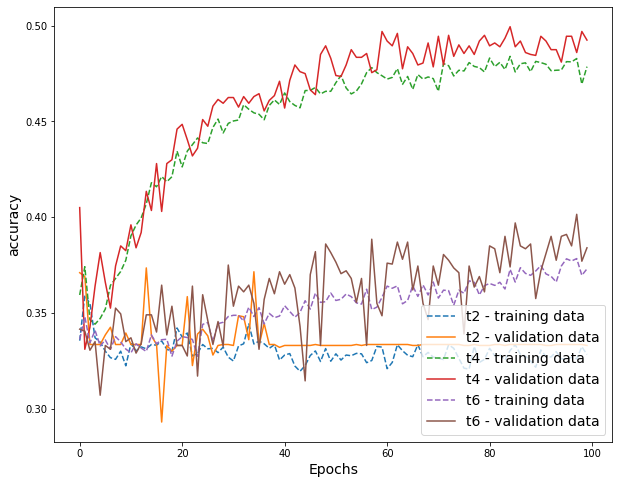

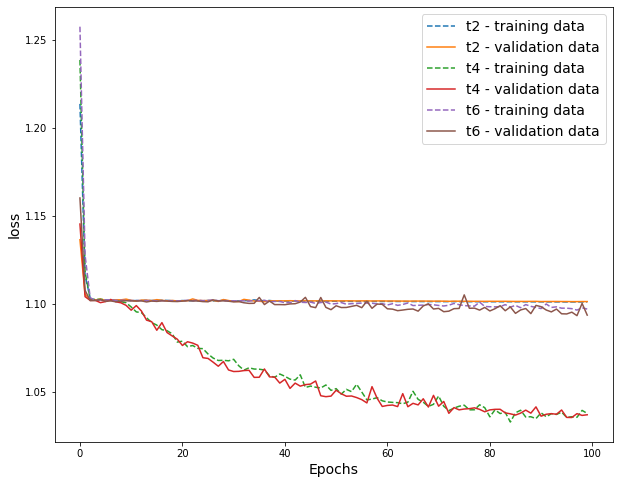

In [23]:
# Grafical comparison

fits = [fit2,fit4,fit6]

plt.close()

# Accuracy
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['accuracy'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['loss'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()

#### Comment
From the learning process, it seems that the `t2` model, the one with 2 convolutional layers and 2 fully connected layers (recall, it has less parameters than `t4`) is the one performing better in the long run, having an accuracy greater that the other models!

The fastest to learn is `t4` related to 1 convolutional layer and 1 fully connected layer but is the worst in the long run. While `t6`, which is like the one used during lessons `3_0X`, stays in the middle.

## 2: Confusion Matrix

As it can be seen from the [relative documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), the `sklearn.metrics.confusion_matrix` function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class, and each column corresponding to the predected one. Notice that [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) and other references may use different convention for axes.

By definition, entry $C_{ij}$ in a confusion matrix $C$ is the number of observations actually in group $i$, but predicted to be in group $j$. Therefore, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

We compute the confusion matrix for the model2, which was the one with the best performance.

In [24]:
from sklearn.metrics import confusion_matrix

# Uncomment to have a look at the test (val) data one more time:
#print('x, of shape {}: \n'.format(x_val.shape), x_val, '\n')
#print('y, of shape {}: \n'.format(y.shape), y_val, '\n')

y_pred = model2.predict(x_val, batch_size = batch_size)
print('The predicted values are:\n', y_pred)

The predicted values are:
 [[0.33264208 0.33410034 0.33325756]
 [0.33264208 0.33410034 0.33325756]
 [0.33264208 0.33410034 0.33325756]
 ...
 [0.33264208 0.33410034 0.33325756]
 [0.33264208 0.33410034 0.33325756]
 [0.33264208 0.33410034 0.33325756]]


In order to compute the confusion matrix, we feed to the confusion_matrix function the index of the maximum value for each row, both for the true labels and for the predicted ones. That index corresponds, moreover, to the wanted category (0 = no signal, 1 = positive signal, 2 = negative signal)

In [25]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(conf_mat)

[[  0 667   0]
 [  0 666   0]
 [  0 667   0]]


Let's do a rapid check: we compute the accuracy of the model as given by the confusion matrix, and visually compare it to the one plotted previously. 

In [26]:
# Sum the element on the diagonal
sum_diag = np.sum(np.diag(conf_mat)) 
# Sum the offdiagonal terms
sum_offd = np.sum(np.extract(1-np.eye(3), conf_mat))

total_n = sum_diag + sum_offd
# Check if it equals the length of y_val (as it should be):
# total_n == len(y_val)

# Computing and printing the accuracy
print('The percentage of corrected categorized data is {} %'.format(100*sum_diag/total_n) )

The percentage of corrected categorized data is 33.3 %


The result is, therefore, qualitatively consistent. 

Let's plot the confusion matrix:

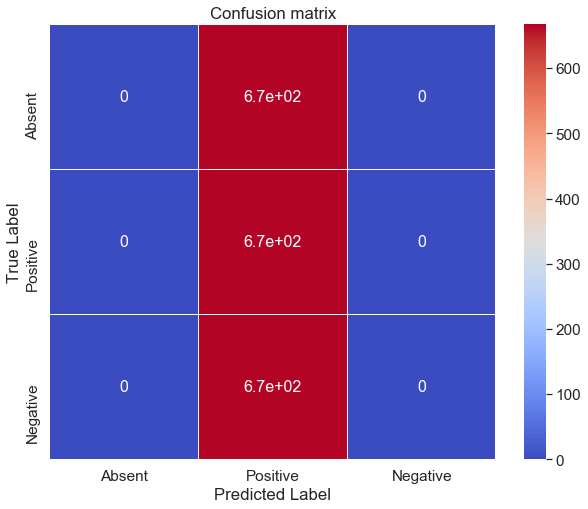

In [27]:
import seaborn as sns
import pandas as pd

# Feed the confusion matrix into a pandas dataframe, to ease the labeling process in the plot
df_cm = pd.DataFrame(conf_mat, columns = ['Absent', 'Positive', 'Negative'],
                    index = ['Absent', 'Positive', 'Negative'])

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="coolwarm",
           linewidths=.5)
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

## 3. Regularization
With two convolutional layers, plot also the weights of the second layer and try to see if regularization may improve the performances by varying the parameter lambda of the L1 or of the L2 regularization; Is any value of lambda good? Is there any intermediate value where the performances of the network are better? Is there any improvement in the visualization and understanding of the weights in the filters? 

In [60]:
def create_regmodel(NCONV=2, n_dense_layers=1, kernel_size_diff=1, summary=False, reg=regularizers.l1(0.1)):

    if n_dense_layers < 1:
        raise('n_dense_layer must be int and >= 1')
        
    # Used to initialize kernel 
    init = initializers.RandomNormal(mean = 0,
                                   stddev = .05)
    model = Sequential()
    model.add( Conv1D(filters=5,
                      kernel_size = 11,                              
                      kernel_initializer = init,
                      kernel_regularizer = reg,
                      activation = 'relu',
                      input_shape = input_size
                     ) )
    model.add( AveragePooling1D(5) ) # max pooling windows' size
    model.add( Flatten() )
    for _ in range(n_dense_layers): # variable number of layers
        model.add( Dense(10, activation='relu') )
    model.add( Dropout(0.2) )
    
    # Output layer
    model.add(Dense(n_class, activation='softmax')) 
    
    # print model's details
    if summary: print(model.summary())
    # Number of trainable parameters
    trainable_count = count_params(model.trainable_weights)
    
    # Compiling model
    opt = optimizers.Nadam()
    model.compile( loss = categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])
    
    return (model, trainable_count)

In [82]:
# import regularizers
from keras.regularizers import l1, l2, l1_l2
# instantiate regularizer
reg11 = l1(0.0001)
reg12 = l1(0.001)
reg13 = l1(0.01)
reg21 = l2(0.0001)
reg22 = l2(0.001)
reg23 = l2(0.01)
reg3 = l1_l2(0.01,0.001)

model_l1_1, _ = create_regmodel(**t4,reg=reg11)
model_l1_2, _ = create_regmodel(**t4,reg=reg12)
model_l1_3, _ = create_regmodel(**t4,reg=reg13)
model_l2_1, _ = create_regmodel(**t4,reg=reg21)
model_l2_2, _ = create_regmodel(**t4,reg=reg22)
model_l2_3, _ = create_regmodel(**t4,reg=reg23)
model_l1_l2, _ = create_regmodel(**t4,reg=reg3)

In [83]:
# retrieve weights from the second hidden layer
fits = []
model_list=[model_l1_1,model_l1_2,model_l1_3,model_l2_1,model_l2_2,model_l2_3, model_l1_l2]
for model in model_list:
    fits.append(model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
               validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True))


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 0s - loss: 1.1022 - accuracy: 0.3444 - val_loss: 1.0901 - val_accuracy: 0.3785
Epoch 2/100
 - 0s - loss: 1.0863 - accuracy: 0.3880 - val_loss: 1.0769 - val_accuracy: 0.4240
Epoch 3/100
 - 0s - loss: 1.0735 - accuracy: 0.4255 - val_loss: 1.0574 - val_accuracy: 0.4630
Epoch 4/100
 - 0s - loss: 1.0558 - accuracy: 0.4469 - val_loss: 1.0383 - val_accuracy: 0.4955
Epoch 5/100
 - 0s - loss: 1.0361 - accuracy: 0.4672 - val_loss: 1.0175 - val_accuracy: 0.5020
Epoch 6/100
 - 0s - loss: 1.0181 - accuracy: 0.4897 - val_loss: 1.0004 - val_accuracy: 0.5130
Epoch 7/100
 - 0s - loss: 1.0037 - accuracy: 0.4963 - val_loss: 0.9897 - val_accuracy: 0.5170
Epoch 8/100
 - 0s - loss: 0.9954 - accuracy: 0.5033 - val_loss: 0.9826 - val_accuracy: 0.5170
Epoch 9/100
 - 0s - loss: 0.9849 - accuracy: 0.5189 - val_loss: 0.9787 - val_accuracy: 0.5175
Epoch 10/100
 - 0s - loss: 0.9783 - accuracy: 0.5231 - val_loss: 0.9735 - val_accuracy: 0.5245
Epoch 11/10

Epoch 87/100
 - 0s - loss: 0.8636 - accuracy: 0.6094 - val_loss: 0.8739 - val_accuracy: 0.6320
Epoch 88/100
 - 0s - loss: 0.8658 - accuracy: 0.6108 - val_loss: 0.8779 - val_accuracy: 0.6195
Epoch 89/100
 - 0s - loss: 0.8636 - accuracy: 0.6110 - val_loss: 0.8728 - val_accuracy: 0.6235
Epoch 90/100
 - 0s - loss: 0.8666 - accuracy: 0.6131 - val_loss: 0.8757 - val_accuracy: 0.6235
Epoch 91/100
 - 0s - loss: 0.8661 - accuracy: 0.6168 - val_loss: 0.8741 - val_accuracy: 0.6240
Epoch 92/100
 - 0s - loss: 0.8662 - accuracy: 0.6086 - val_loss: 0.8697 - val_accuracy: 0.6255
Epoch 93/100
 - 0s - loss: 0.8634 - accuracy: 0.6065 - val_loss: 0.8706 - val_accuracy: 0.6310
Epoch 94/100
 - 0s - loss: 0.8592 - accuracy: 0.6137 - val_loss: 0.8723 - val_accuracy: 0.6225
Epoch 95/100
 - 0s - loss: 0.8585 - accuracy: 0.6158 - val_loss: 0.8712 - val_accuracy: 0.6290
Epoch 96/100
 - 0s - loss: 0.8571 - accuracy: 0.6139 - val_loss: 0.8714 - val_accuracy: 0.6300
Epoch 97/100
 - 0s - loss: 0.8540 - accuracy: 0.62

Epoch 73/100
 - 0s - loss: 0.9019 - accuracy: 0.5834 - val_loss: 0.9100 - val_accuracy: 0.5885
Epoch 74/100
 - 0s - loss: 0.8999 - accuracy: 0.5866 - val_loss: 0.9128 - val_accuracy: 0.5915
Epoch 75/100
 - 0s - loss: 0.9040 - accuracy: 0.5872 - val_loss: 0.9139 - val_accuracy: 0.5815
Epoch 76/100
 - 0s - loss: 0.8996 - accuracy: 0.5865 - val_loss: 0.9071 - val_accuracy: 0.5910
Epoch 77/100
 - 0s - loss: 0.9018 - accuracy: 0.5854 - val_loss: 0.9057 - val_accuracy: 0.5995
Epoch 78/100
 - 0s - loss: 0.8970 - accuracy: 0.5881 - val_loss: 0.9062 - val_accuracy: 0.5905
Epoch 79/100
 - 0s - loss: 0.9033 - accuracy: 0.5817 - val_loss: 0.9039 - val_accuracy: 0.5965
Epoch 80/100
 - 0s - loss: 0.9016 - accuracy: 0.5928 - val_loss: 0.9071 - val_accuracy: 0.5955
Epoch 81/100
 - 0s - loss: 0.8996 - accuracy: 0.5863 - val_loss: 0.9049 - val_accuracy: 0.6000
Epoch 82/100
 - 0s - loss: 0.9015 - accuracy: 0.5822 - val_loss: 0.9037 - val_accuracy: 0.5970
Epoch 83/100
 - 0s - loss: 0.8999 - accuracy: 0.58

Epoch 59/100
 - 0s - loss: 0.9371 - accuracy: 0.5723 - val_loss: 0.9485 - val_accuracy: 0.5895
Epoch 60/100
 - 0s - loss: 0.9421 - accuracy: 0.5695 - val_loss: 0.9485 - val_accuracy: 0.5810
Epoch 61/100
 - 0s - loss: 0.9388 - accuracy: 0.5810 - val_loss: 0.9505 - val_accuracy: 0.5715
Epoch 62/100
 - 0s - loss: 0.9429 - accuracy: 0.5732 - val_loss: 0.9502 - val_accuracy: 0.5755
Epoch 63/100
 - 0s - loss: 0.9396 - accuracy: 0.5735 - val_loss: 0.9546 - val_accuracy: 0.5785
Epoch 64/100
 - 0s - loss: 0.9363 - accuracy: 0.5828 - val_loss: 0.9469 - val_accuracy: 0.5865
Epoch 65/100
 - 0s - loss: 0.9416 - accuracy: 0.5746 - val_loss: 0.9491 - val_accuracy: 0.5785
Epoch 66/100
 - 0s - loss: 0.9412 - accuracy: 0.5763 - val_loss: 0.9600 - val_accuracy: 0.5700
Epoch 67/100
 - 0s - loss: 0.9365 - accuracy: 0.5741 - val_loss: 0.9483 - val_accuracy: 0.5785
Epoch 68/100
 - 0s - loss: 0.9357 - accuracy: 0.5811 - val_loss: 0.9478 - val_accuracy: 0.5810
Epoch 69/100
 - 0s - loss: 0.9350 - accuracy: 0.57

Epoch 45/100
 - 0s - loss: 0.9313 - accuracy: 0.5605 - val_loss: 0.9362 - val_accuracy: 0.5730
Epoch 46/100
 - 0s - loss: 0.9251 - accuracy: 0.5692 - val_loss: 0.9350 - val_accuracy: 0.5770
Epoch 47/100
 - 0s - loss: 0.9257 - accuracy: 0.5640 - val_loss: 0.9337 - val_accuracy: 0.5770
Epoch 48/100
 - 0s - loss: 0.9252 - accuracy: 0.5621 - val_loss: 0.9366 - val_accuracy: 0.5725
Epoch 49/100
 - 0s - loss: 0.9245 - accuracy: 0.5669 - val_loss: 0.9325 - val_accuracy: 0.5715
Epoch 50/100
 - 0s - loss: 0.9222 - accuracy: 0.5638 - val_loss: 0.9322 - val_accuracy: 0.5730
Epoch 51/100
 - 0s - loss: 0.9219 - accuracy: 0.5666 - val_loss: 0.9316 - val_accuracy: 0.5735
Epoch 52/100
 - 0s - loss: 0.9254 - accuracy: 0.5648 - val_loss: 0.9323 - val_accuracy: 0.5735
Epoch 53/100
 - 0s - loss: 0.9193 - accuracy: 0.5716 - val_loss: 0.9328 - val_accuracy: 0.5740
Epoch 54/100
 - 0s - loss: 0.9203 - accuracy: 0.5720 - val_loss: 0.9303 - val_accuracy: 0.5760
Epoch 55/100
 - 0s - loss: 0.9208 - accuracy: 0.56

Epoch 31/100
 - 0s - loss: 0.9270 - accuracy: 0.5655 - val_loss: 0.9234 - val_accuracy: 0.5830
Epoch 32/100
 - 0s - loss: 0.9317 - accuracy: 0.5644 - val_loss: 0.9220 - val_accuracy: 0.5835
Epoch 33/100
 - 0s - loss: 0.9183 - accuracy: 0.5760 - val_loss: 0.9216 - val_accuracy: 0.5810
Epoch 34/100
 - 0s - loss: 0.9242 - accuracy: 0.5707 - val_loss: 0.9193 - val_accuracy: 0.5850
Epoch 35/100
 - 0s - loss: 0.9182 - accuracy: 0.5757 - val_loss: 0.9180 - val_accuracy: 0.5865
Epoch 36/100
 - 0s - loss: 0.9221 - accuracy: 0.5755 - val_loss: 0.9178 - val_accuracy: 0.5895
Epoch 37/100
 - 0s - loss: 0.9197 - accuracy: 0.5725 - val_loss: 0.9147 - val_accuracy: 0.5895
Epoch 38/100
 - 0s - loss: 0.9180 - accuracy: 0.5753 - val_loss: 0.9149 - val_accuracy: 0.5995
Epoch 39/100
 - 0s - loss: 0.9130 - accuracy: 0.5788 - val_loss: 0.9134 - val_accuracy: 0.5920
Epoch 40/100
 - 0s - loss: 0.9151 - accuracy: 0.5755 - val_loss: 0.9123 - val_accuracy: 0.5975
Epoch 41/100
 - 0s - loss: 0.9143 - accuracy: 0.57

Epoch 17/100
 - 0s - loss: 0.9620 - accuracy: 0.5406 - val_loss: 0.9570 - val_accuracy: 0.5525
Epoch 18/100
 - 0s - loss: 0.9547 - accuracy: 0.5564 - val_loss: 0.9545 - val_accuracy: 0.5435
Epoch 19/100
 - 0s - loss: 0.9534 - accuracy: 0.5504 - val_loss: 0.9498 - val_accuracy: 0.5620
Epoch 20/100
 - 0s - loss: 0.9498 - accuracy: 0.5484 - val_loss: 0.9472 - val_accuracy: 0.5565
Epoch 21/100
 - 0s - loss: 0.9491 - accuracy: 0.5501 - val_loss: 0.9469 - val_accuracy: 0.5620
Epoch 22/100
 - 0s - loss: 0.9509 - accuracy: 0.5502 - val_loss: 0.9489 - val_accuracy: 0.5595
Epoch 23/100
 - 0s - loss: 0.9438 - accuracy: 0.5615 - val_loss: 0.9419 - val_accuracy: 0.5620
Epoch 24/100
 - 0s - loss: 0.9442 - accuracy: 0.5560 - val_loss: 0.9398 - val_accuracy: 0.5675
Epoch 25/100
 - 0s - loss: 0.9471 - accuracy: 0.5565 - val_loss: 0.9394 - val_accuracy: 0.5760
Epoch 26/100
 - 0s - loss: 0.9389 - accuracy: 0.5592 - val_loss: 0.9359 - val_accuracy: 0.5645
Epoch 27/100
 - 0s - loss: 0.9412 - accuracy: 0.56

Epoch 3/100
 - 0s - loss: 1.0932 - accuracy: 0.3941 - val_loss: 1.0885 - val_accuracy: 0.4060
Epoch 4/100
 - 0s - loss: 1.0812 - accuracy: 0.4195 - val_loss: 1.0761 - val_accuracy: 0.4375
Epoch 5/100
 - 0s - loss: 1.0688 - accuracy: 0.4449 - val_loss: 1.0702 - val_accuracy: 0.4515
Epoch 6/100
 - 0s - loss: 1.0581 - accuracy: 0.4656 - val_loss: 1.0555 - val_accuracy: 0.4615
Epoch 7/100
 - 0s - loss: 1.0443 - accuracy: 0.4785 - val_loss: 1.0345 - val_accuracy: 0.4925
Epoch 8/100
 - 0s - loss: 1.0333 - accuracy: 0.4914 - val_loss: 1.0294 - val_accuracy: 0.5010
Epoch 9/100
 - 0s - loss: 1.0265 - accuracy: 0.4954 - val_loss: 1.0265 - val_accuracy: 0.5115
Epoch 10/100
 - 0s - loss: 1.0149 - accuracy: 0.5010 - val_loss: 1.0099 - val_accuracy: 0.5020
Epoch 11/100
 - 0s - loss: 1.0122 - accuracy: 0.5046 - val_loss: 1.0109 - val_accuracy: 0.5150
Epoch 12/100
 - 0s - loss: 1.0078 - accuracy: 0.5090 - val_loss: 1.0055 - val_accuracy: 0.5255
Epoch 13/100
 - 0s - loss: 1.0043 - accuracy: 0.5102 - va

Epoch 90/100
 - 0s - loss: 0.9297 - accuracy: 0.5731 - val_loss: 0.9423 - val_accuracy: 0.5800
Epoch 91/100
 - 0s - loss: 0.9341 - accuracy: 0.5732 - val_loss: 0.9405 - val_accuracy: 0.5830
Epoch 92/100
 - 0s - loss: 0.9320 - accuracy: 0.5735 - val_loss: 0.9447 - val_accuracy: 0.5830
Epoch 93/100
 - 0s - loss: 0.9317 - accuracy: 0.5760 - val_loss: 0.9407 - val_accuracy: 0.5795
Epoch 94/100
 - 0s - loss: 0.9309 - accuracy: 0.5714 - val_loss: 0.9377 - val_accuracy: 0.5870
Epoch 95/100
 - 0s - loss: 0.9293 - accuracy: 0.5699 - val_loss: 0.9412 - val_accuracy: 0.5820
Epoch 96/100
 - 0s - loss: 0.9297 - accuracy: 0.5790 - val_loss: 0.9419 - val_accuracy: 0.5790
Epoch 97/100
 - 0s - loss: 0.9300 - accuracy: 0.5760 - val_loss: 0.9397 - val_accuracy: 0.5810
Epoch 98/100
 - 0s - loss: 0.9338 - accuracy: 0.5716 - val_loss: 0.9382 - val_accuracy: 0.5845
Epoch 99/100
 - 0s - loss: 0.9306 - accuracy: 0.5773 - val_loss: 0.9378 - val_accuracy: 0.5810
Epoch 100/100
 - 0s - loss: 0.9331 - accuracy: 0.5

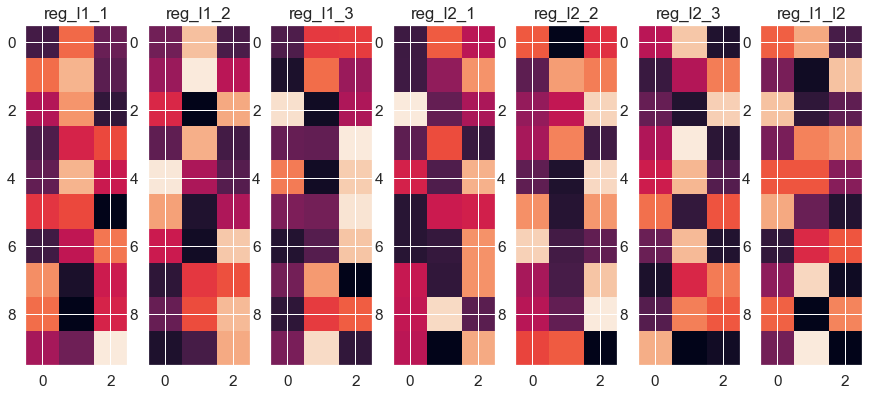

In [98]:

fig, ax = plt.subplots(1,7,figsize=(15,7))
ax_dict={}
ax_dict = {'reg_l1_1': ax[0], 'reg_l1_2': ax[1], 'reg_l1_3': ax[2], 'reg_l2_1': ax[3], 'reg_l2_2': ax[4],
          'reg_l2_3': ax[5], 'reg_l1_l2': ax[6]}

#Setting names
for key in ax_dict:
    ax_dict[key].set_title(key)
    
for model, reg in zip(model_list, ax_dict.keys()):    
    filters, biases = model.layers[-1].get_weights()
    ff = pd.DataFrame(filters)
    ax_dict[reg].imshow(ff)
    #sns.set(font_scale=1.4) # for label size
    #sns.heatmap(ff, annot=True, annot_kws={"size": 16}, cmap="GnBu",
          # linewidths=.5)

plt.show()


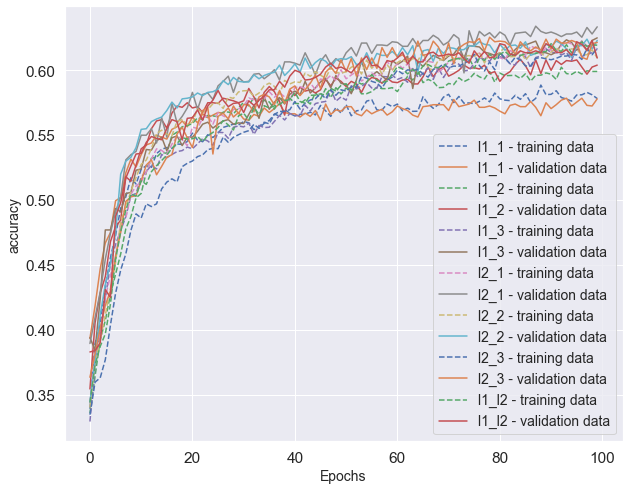

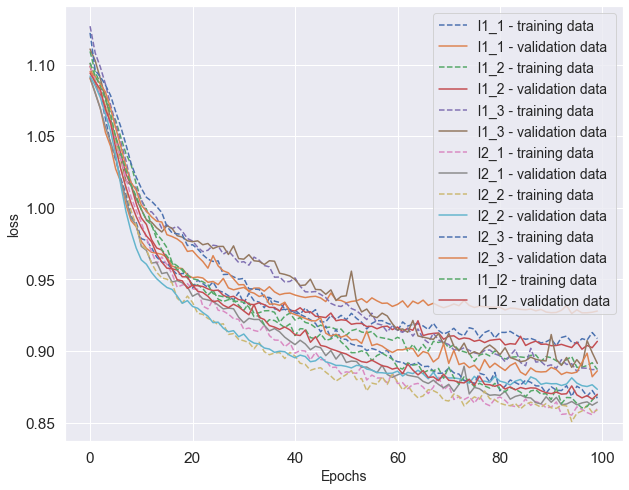

In [79]:
reg=['l1_1','l1_2','l1_3','l2_1','l2_2','l2_3','l1_l2']
# Accuracy
plt.figure(figsize=(10,8))
for fit ,test in zip(fits,reg):
    
    plt.plot(fit.history['accuracy'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,reg):
    
    plt.plot(fit.history['loss'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()